In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.insert(0, os.path.abspath('../rtl-spectrogram/pll'))

from Orig_PLL import PhaseLockedLoop
from Fast_PLL import Fast_PhaseLockedLoop


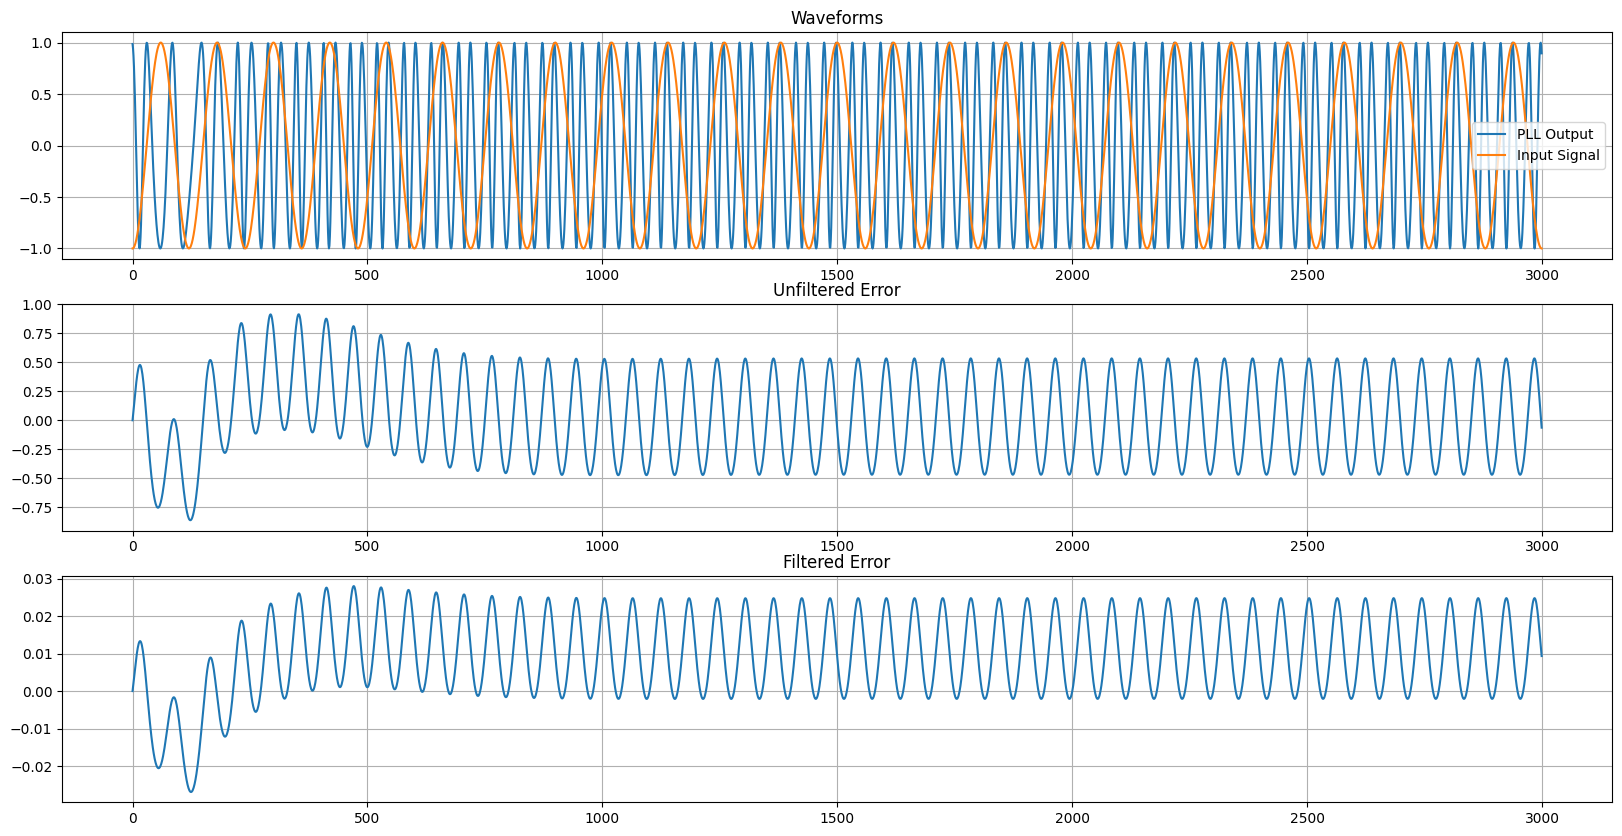

In [8]:
# These fuckers have to be scaled. This may imply that something in the PLL needs
# to be scaled by fs (or it really is that these values need to scale)
K = 1
fs = 150 * K * 10
K_p = 0.2667 / 10
K_i = 0.0178 * 10
K_0 = 1
duration_secs = 2 / K
in_f_Hz   = 10*K

t = np.linspace(0,duration_secs, int(duration_secs*fs))

in_A      = 1

# in_phi    = np.random.normal(0, 0.0, size=len(t)) + np.pi
in_phi    = np.pi
# in_phi    = 0
in_sig    = in_A * np.cos( 2*np.pi * in_f_Hz*1.25 * t + in_phi )
# in_sig    += np.random.normal(0, 0.0, size=len(t)) # AWGN

e_D = [] # phase-error output
e_F = [] #Filtered phase-error output
cos_out = []



pll = Fast_PhaseLockedLoop( K_i, K_p, K_0, in_f_Hz, fs, f_multiplier=4 )
for n in range(len(t)):
    _cos_out, _sin_out, _e_D, _e_F = pll.proc( in_sig[n] )
    
    cos_out.append( _cos_out )
    e_D.append( _e_D )
    e_F.append( _e_F )

# Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

# Set up Axes
ax1 = fig.add_subplot(311)
# ax1.plot(cos_out[int(-fs/in_f_Hz)*10:], label='PLL Output')
ax1.plot(cos_out, label='PLL Output')
plt.grid()
# ax1.plot(in_sig[int(-fs/in_f_Hz)*10:], label='Input Signal')
ax1.plot(in_sig, label='Input Signal')
plt.legend()
ax1.set_title('Waveforms')

# Show the plot
#plt.show()

ax2 = fig.add_subplot(312)
ax2.plot( e_D )
plt.grid()
ax2.set_title('Unfiltered Error')

ax3 = fig.add_subplot(313)
ax3.plot( e_F )
plt.grid()
ax3.set_title('Filtered Error')
plt.show()

In [3]:
# OK, what does the phase detector do?

fs = 100
duration_secs = 2
t = np.linspace(0,duration_secs, int(duration_secs*fs))

a = 2.0 * np.sin( 2*np.pi * 4*t+0.5 )
b = 2.0 * np.sin( 2*np.pi * 4*t )

pd = PhaseDetector()

phase = []
for i in range(len(a)):
    phase.append( pd.proc( a[i], b[i] ) )

    # Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

ax1 = fig.add_subplot(111)
ax1.plot(a, label='signal a', alpha=0.5 )
ax1.plot(b, label='signal b', alpha=0.5 )
ax1.plot(phase, label='Phase Delta')
plt.grid()
plt.legend()
ax1.set_title('Waveforms')

NameError: name 'PhaseDetector' is not defined

In [ ]:
# OK what does the loop filter do?
# OK, what does the phase detector do?

class LoopFilter:
    def __init__( self, K_i, K_p ) -> None:
        self.K_i = K_i
        self.K_p = K_p
        self.integrator = 0
    
    def proc( self, e_D ):
        self.integrator += self.K_i * e_D / fs
#         return self.integrator
        return self.K_p * e_D + self.integrator

K_p = 0.025
K_i = 5
# K_i = 1.0

fs = 20000
duration_secs = 5
t = np.linspace(0,duration_secs, int(duration_secs*fs))

a = 1.0 * np.sin( 2*np.pi * 1*t )
b = 1.00 * np.sin( 2*np.pi * 50*t )
s = a+b

pd = PhaseDetector()
lf = LoopFilter( K_i, K_p )

phase = []
filtered = []
for i in range(len(a)):
    filtered.append ( lf.proc( s[i] ) )
    # Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

ax2 = fig.add_subplot(211)
ax2.plot(s, label='Sum')
ax2.plot(filtered, label='Filtered')
plt.grid()
plt.legend()
ax2.set_title('Waveforms')

In [ ]:
# Alright what's with the NCO

class NumericallyControlledOscillator:
    def __init__( self, K_0, f, fs ) -> None:
        self.K_0 = K_0
        self.f = f
        self.fs = fs
        self.theta = 0
                
        self.nextPhaseEstimate = 0
        self.nextCosOut = 1
        self.nextSinOut = 0

    def proc( self, e_F ):
        e_F /= self.fs
        phaseEstimate = self.nextPhaseEstimate
        
        self.theta += 2*np.pi*self.f/self.fs
        if self.theta > 2*np.pi:
            self.theta -= 2*np.pi

            
        ret = (self.nextCosOut, self.nextSinOut)
        
        self.nextPhaseEstimate = (phaseEstimate + self.K_0 * e_F)
        self.nextCosOut = np.cos( self.theta + phaseEstimate )
        self.nextSinOut = -np.sin( self.theta + phaseEstimate )
                
        return ret
    
    
fs = 15000
K_0 = 1
duration_secs = 2
in_f_Hz   = 10
t = np.linspace(0,duration_secs, int(duration_secs*fs))
in_A      = 1

# in_phi    = np.random.normal(0, 0.0, size=len(t)) + np.pi
in_phi    = np.pi
in_sig    = in_A * np.cos( 2*np.pi * in_f_Hz * t + in_phi )
# in_sig    += np.random.normal(0, 0.0, size=len(t)) # AWGN

e_D = [] # phase-error output
e_F = [] #Filtered phase-error output
cos_out = []


nco = NumericallyControlledOscillator( K_0, 10, fs )
for n in range(len(t)):
    _cos_out, _sin_out = nco.proc( 2*np.pi*10 )
    cos_out.append( _cos_out )
    

# Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

# Set up Axes
ax1 = fig.add_subplot(211)
# ax1.plot(cos_out[int(-fs/in_f_Hz)*10:], label='PLL Output')
ax1.plot(cos_out, label='NCO Output')
plt.grid()
# ax1.plot(in_sig[int(-fs/in_f_Hz)*10:], label='Input Signal')
ax1.plot(sigIn, label='Input Signal')
plt.legend()
ax1.set_title('Waveforms')

# Show the plot
#plt.show()

ax2 = fig.add_subplot(212)
ax2.plot( e_D )
plt.grid()
ax2.set_title('Filtered Error')
plt.show()


In [ ]:
# OK, what does the phase detector and filter do together?

fs = 1000
K_p = 0.2667
K_i = 0.0178

duration_secs = 50
t = np.linspace(0,duration_secs, int(duration_secs*fs))

# in_phi    = np.random.normal(0, 0.1, size=len(t)) + np.pi
in_phi    = np.pi
in_phi    = 0

f = 1
a = 2.0 * np.sin( 2*np.pi * f*t+in_phi )
b = 2.0 * np.sin( 2*np.pi * f*t )

pd = PhaseDetector()
lf = LoopFilter( K_i, K_p )
phase = []
filt = []
for i in range(len(a)):
    phase.append( pd.proc( a[i], b[i] ) )
    filt.append( lf.proc( phase[-1] ) )

    # Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

ax1 = fig.add_subplot(211)
ax1.plot(a, label='signal a', alpha=0.5 )
ax1.plot(b, label='signal b', alpha=0.5 )
ax1.plot(phase, label='Phase Error')
plt.grid()
plt.legend()
ax1.set_title('Waveforms')

ax1 = fig.add_subplot(212)

ax1.plot(filt, label='Filtered Phase Delta')

In [ ]:
# OK what does the loop filter do?
# OK, what does the phase detector do?

class LoopFilter:
    def __init__( self, K_i, K_p ) -> None:
        self.K_i = K_i
        self.K_p = K_p
        self.integrator = 0
    
    def proc( self, e_D ):
        self.integrator += self.K_i * e_D / fs
        return self.K_p * e_D + self.integrator

K_p = 0.025
K_i = 10
# K_i = 1.0

fs = 20000
duration_secs = 5
t = np.linspace(0,duration_secs, int(duration_secs*fs))

a = 1.0 * np.sin( 2*np.pi * 10*t )
b = 1.00 * np.sin( 2*np.pi * 10*t + 1)
s = s*b

pd = PhaseDetector()
lf = LoopFilter( K_i, K_p )

phase = []
filtered = []
for i in range(len(a)):
    filtered.append ( lf.proc( s[i] ) )
    # Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

ax2 = fig.add_subplot(211)
ax2.plot(s, label='Sum')
ax2.plot(filtered, label='Filtered')
plt.grid()
plt.legend()
ax2.set_title('Waveforms')